In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
import sys, os

# declare a class for molecules
class Molecule:
    
        def __init__(self):
                #start by defining some physical constants
                self.R = 8.3144621E-3 #ideal Gas constant in kJ/mol-K
                self.kB = 1.38065e-23 #Boltzmann constant in J/K
                self.h = 6.62607e-34 #Planck constant in J*s
                self.c = 2.99792458e8 #speed of light in m/s
                self.amu = 1.6605e-27 #atomic mass unit in kg
                self.Avogadro = 6.0221E23 #mole^-1
                self.eV_to_kJpermole = 96.485 #convert eV/molecule to kJ/mol
                self.rydberg_to_eV = 13.6056980659 #convert Ry/molecule to eV/molecule
                self.scale_BEEF = 0.683 #0.683 scaling factor for the BEEF ensemble #0.4 for C2H6 and CH4 dissociation
                self.dHfatct={'CH4':-66.557,'H2O':-238.929,'H2':0,'NH3':-38.565}#heats of formation (0K) in kJ/mol from the ATcT database for the reference species, version 1.122r (5/13/2022)
                self.Eref={'CH4':-324.294,'H2O':-611.0186083,'H2':-32.6984442,'NH3':-442.6510481} #DFT energies of the reference species (ZPE corrected) in eV
                self.Eslab=-377616.072 #DFT energy of the slab in eV
                self.molecular_mass_elements={'H': 1.01, 'C': 12.01, 'N': 14, 'O': 16}
                self.cutoff_frequency = 100.0 #cm^-1
                self.is_twoD_gas = False
                self.tst_twoD_gas = False
                self.N_BEE=2000
                self.GHz_to_Hz = 1.0E9 #convert rotational constants from GHz to Hz
                self.invcm_to_invm = 1.0E2 #convert cm^-1 to m^-1, for frequencies
                self.P_ref = 1.0E5 #reference pressure, 1 bar = 1E5 Pascal
                self.site_occupation_number = 1 #number of sites occupied by adsorbate
                self.unit_cell_area = 62.348e-20/9.0 #m2 - using surface area per binding site (nine binding sites per unit 
                
# create the array of temperatures in 5 degree increments
temperature = [298.15] #NOTE 298.15 must be first for the NASA polynomial routine to work!
T_low = 300
T_high = 1500
dT = 10.0 #temperature increment
temperature = np.append(temperature, np.arange(T_low, T_high+dT, dT) )

In [9]:
# subroutine for the translational mode
def get_translation_thermo(molecule,temperature):
    # unpack the constants (not essential, but makes it easier to read)
    R = molecule.R
    kB = molecule.kB
    h = molecule.h
    amu = molecule.amu
    P_ref = molecule.P_ref
    #calculate the molecular mass from the composition
    m=molecule.composition['H']*molecule.molecular_mass_elements['H']
    m+=molecule.composition['O']*molecule.molecular_mass_elements['O']
    m+=molecule.composition['C']*molecule.molecular_mass_elements['C']
    m+=molecule.composition['N']*molecule.molecular_mass_elements['N']
    pi = np.pi
    area = molecule.unit_cell_area
    sites = molecule.site_occupation_number

    #initialize the arrays for the partition function and the entropy
    Q_trans_is  = np.ones(len(temperature)) 
    S_trans_is  = np.zeros(len(temperature))

    if molecule.is_twoD_gas:
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref #This is volume per molecule of an ideal gas
                Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans_is[i] = R * (2.5 + np.log( Q_trans_is[i] )) 
            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans_is[i] = R * (2.0 + np.log( Q_trans_is[i] ))   
                else: #area is not a function of temperature
                    Q_trans_is[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans_is[i] = R * (2.0 + np.log( Q_trans_is[i] ))
       
    # add the results to the thermo object
    molecule.Q_trans_is = Q_trans_is
    molecule.S_trans_is = S_trans_is
    
    #initialize the arrays for the partition function and the entropy
    Q_trans_tst  = np.ones(len(temperature)) 
    S_trans_tst  = np.zeros(len(temperature))

    if molecule.tst_twoD_gas:
        print("switching to 2D-gas for 2 lowest modes for %s"%molecule.name)
        # cycle through each temperature
        for (i,T) in enumerate(temperature):
            # partition function is: (2*pi*mass*kB*T/h**2)^(2/2) * area
            if (1==0): #3D gas, really here just for inspiration
                V = kB*T/P_ref #This is volume per molecule of an ideal gas
                Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2)**(1.5) * V
                S_trans_tst[i] = R * (2.5 + np.log( Q_trans_tst[i] )) 
            else: #surface
                if (1==0): #Campbell + Arnadottir
                    V = kB*T/P_ref
                    Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2)**(1.0) *V**0.66667
                    S_trans_tst[i] = R * (2.0 + np.log( Q_trans_tst[i] ))   
                else: #area is not a function of temperature
                    Q_trans_tst[i] = (2*pi*m*amu*kB*T/h**2) * area * sites
                    S_trans_tst[i] = R * (2.0 + np.log( Q_trans_tst[i] ))
       
    # add the results to the thermo object
    molecule.Q_trans_tst = Q_trans_tst
    molecule.S_trans_tst = S_trans_tst
    
    return

# subroutine for the vibrational mode
def get_vibrational_thermo(molecule,temperature):

    units = 1.0
    units *= molecule.h * molecule.c / molecule.kB * molecule. invcm_to_invm # K*cm
    
    #initialize the arrays for the partition function and the entropy
    Q_vib_is  = np.ones(len(temperature))
    S_vib_is  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.is_frequencies):
            if molecule.is_twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib_is[t] *= 1.0
                S_vib_is[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib_is[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib_is[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
        S_vib_is[t]  *= molecule.R
    # add the results to the thermo object
    molecule.Q_vib_is = Q_vib_is
    molecule.S_vib_is = S_vib_is
    
    
    #initialize the arrays for the partition function and the entropy
    Q_vib_tst  = np.ones(len(temperature))
    S_vib_tst  = np.zeros(len(temperature))
    
    for (t,temp) in enumerate(temperature):
        for (n,nu) in enumerate(molecule.tst_frequencies):
            if molecule.tst_twoD_gas==True and n <= 1: #skip the first two if we do 2D gas
                #do nothing!
                Q_vib_tst[t] *= 1.0
                S_vib_tst[t] += 0.0
            else:
                x = nu * units / temp #cm^-1 * K cm / K = dimensionless
                Q_vib_tst[t]  *= 1.0 / (1.0 - np.exp( - x) )
                S_vib_tst[t]  += -np.log( 1.0 - np.exp( - x ) ) + x * np.exp( - x) / (1.0 - np.exp( - x) ) 
        S_vib_tst[t]  *= molecule.R
    # add the results to the thermo object
    molecule.Q_vib_tst = Q_vib_tst
    molecule.S_vib_tst = S_vib_tst
    
    return

#-------------------------------------------------------------------------
#create the main thermo function that calls the individual modes
def thermo(molecule, temperature):
    
    # call the subroutine for the vibrational partition function
    get_translation_thermo(molecule,temperature)
    get_vibrational_thermo(molecule,temperature)
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q_is = molecule.Q_trans_is * molecule.Q_vib_is
    molecule.S_is = molecule.S_trans_is + molecule.S_vib_is
    
    # note that the partition function is the production of the individual terms,
    # whereas the thermodynamic properties are additive
    molecule.Q_tst = molecule.Q_trans_tst * molecule.Q_vib_tst
    molecule.S_tst = molecule.S_trans_tst + molecule.S_vib_tst
    
    return

def parse_input_file(inputfile, molecule):
    
    script_dir=''
    rel_path =  str(inputfile) + '.dat'
    abs_file_path = os.path.join(script_dir, rel_path)
    
    molecule.output_file="".join((inputfile,'-bee.txt'))
    
    input_file = open(abs_file_path,'r')
    lines = input_file.readlines()
    input_file.close()
    
    error_name = True
    error_DFT_binding_energy = True
    error_composition = True
    error_sites = True
    error_adsorbate_mass = True
    error_is_frequencies = True
    error_tst_frequencies = True
    error_is_bee = True
    error_tst_bee = True
    
    for line in lines:
        #start by looking for the name
        if line.strip().startswith("name"):
            bits = line.split('=')
            name = bits[1].strip().replace("'","").replace('"','')
            molecule.name = name
            error_name = False
        #now look for the DFT energy    
        elif line.strip().startswith("IS_SPE"):
            bits = line.split('=') 
            is_SPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            is_SPE = float(is_SPE_info[0])
            units = is_SPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.is_SPE = is_SPE
                molecule.is_SPE_units = units.strip()
                error_is_SPE = False
            else:
                print ("DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("IS_ZPE"):
            bits = line.split('=') 
            is_ZPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            is_ZPE = float(is_ZPE_info[0])
            units = is_ZPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.is_ZPE = is_ZPE
                molecule.is_ZPE_units = units.strip()
                error_is_ZPE = False
            else:
                print ("ZPE energy is missing proper units!\n Please use 'eV'")
                break
        #now look for the DFT energy    
        elif line.strip().startswith("TST_SPE"):
            bits = line.split('=') 
            tst_SPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            tst_SPE = float(tst_SPE_info[0])
            units = tst_SPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.tst_SPE = tst_SPE
                molecule.tst_SPE_units = units.strip()
                error_tst_SPE = False
            else:
                print ("gas DFT energy is missing proper units!\n Please use 'eV'")
                break
           
        #now look for the ZPE energy    
        elif line.strip().startswith("TST_ZPE"):
            bits = line.split('=') 
            tst_ZPE_info = bits[1].strip().replace("[","").replace("]","").split(',')
            tst_ZPE = float(tst_ZPE_info[0])
            units = tst_ZPE_info[1].strip().replace("'","").replace('"','')
            if units=='eV':
                molecule.tst_ZPE = tst_ZPE
                molecule.tst_ZPE_units = units.strip()
                error_tst_ZPE = False
            else:
                print ("gas ZPE energy is missing proper units!\n Please use 'eV'")
                break
                
        #now look for the composition    
        elif line.strip().startswith("composition"):
            bits = line.split('=') 
            composition = bits[1].strip().replace("{","").replace("}","").split(',')
            molecule.composition = {}
            for pair in composition:
                element, number = pair.split(":")
                element = element.strip().replace("'","").replace('"','')
                number = int(number)
                molecule.composition[element]=number
            N_adsorbate_atoms = 0
            for element in molecule.composition:
                if element!='Pt':
                    N_adsorbate_atoms += molecule.composition[element]            
            error_composition = False
        #now look for the site occupancy    
        elif line.strip().startswith("sites"):
            bits = line.split('=') 
            site_occupation_number = int(bits[1])
            molecule.site_occupation_number = site_occupation_number
            error_sites = False  

        #now look for the frequencies of the transition state   
        elif line.strip().startswith("IS_frequencies"):
            bits = line.split('=')
            is_freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = 3*N_adsorbate_atoms
            if len(is_freq_info)!=N_freq_computed+1:
                print ("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(is_freq_info)-1))
            units = is_freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.frequencies_units = units.strip()
                molecule.is_frequencies = []
                for i in range(len(is_freq_info)-1):
                    molecule.is_frequencies.append(float(is_freq_info[i]))
                error_is_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.is_frequencies[1]<molecule.cutoff_frequency:
                    #print "switching to 2D-gas for 2 lowest modes for %s"%name
                    molecule.is_twoD_gas = False
                    
        elif line.strip().startswith("TST_frequencies"):
            bits = line.split('=')
            tst_freq_info = bits[1].strip().replace("[","").replace("]","").split(',')
            N_freq_computed = 3*N_adsorbate_atoms-1
            if len(tst_freq_info)!=N_freq_computed+1:
                print ("ERROR: The number of frequencies is not what was expected\n %d expected, but only %d received"%(N_freq_computed, len(tst_freq_info)-1))
            units = tst_freq_info[-1]    
            if units=='eV' or units!='cm-1':
                molecule.tst_frequencies_units = units.strip()
                molecule.tst_frequencies = []
                for i in range(len(tst_freq_info)-1):
                    molecule.tst_frequencies.append(float(tst_freq_info[i]))
                error_tst_frequencies = False
                #if the two lowest frequencies are less than the cutoff value (This assumes that they are sorted!)
                if molecule.tst_frequencies[1]<molecule.cutoff_frequency:
                    #print "switching to 2D-gas for 2 lowest modes for %s"%name
                    molecule.tst_twoD_gas = False
                    
                #now look for the BEE   
        elif line.strip().startswith("bee_IS"):
            bits = line.split('=') 
            is_bee_data_info = bits[1].strip().replace("[","").replace("]","").split(',')
            is_bee_data = is_bee_data_info
            molecule.is_bee_energies = []
            for i in range(len(is_bee_data)):
                    molecule.is_bee_energies.append(float(is_bee_data[i]))
            if len(is_bee_data)==molecule.N_BEE:
                    error_is_bee = False
            else:
                print ("The number of sample of the IS BEE is not 2000!\n Please check again!")
                break      
        #now look for the gas BEE   
        elif line.strip().startswith("bee_TS"):
            bits = line.split('=') 
            tst_bee_data_info = bits[1].strip().replace("[","").replace("]","").split(',')
            tst_bee_data = tst_bee_data_info
            molecule.tst_bee_energies = []
            for i in range(len(tst_bee_data)):
                    molecule.tst_bee_energies.append(float(tst_bee_data[i]))

            if len(tst_bee_data)==molecule.N_BEE:
                    error_tst_bee = False
            else:
                print ("The number of sample of the TS BEE is not 2000!\n Please check again!")
                break
                    
    if error_name or error_composition or error_is_frequencies or error_tst_frequencies or error_tst_bee or error_is_bee:
        print ("Input file is missing information: %s"%(inputfile))
    else:
        print ("successfully parsed file %s"%(inputfile))
    
    return                

def compute_ensemble(molecule):
    
    N_BEE=molecule.N_BEE
    eV_to_kJpermole=molecule.eV_to_kJpermole
    scale_BEEF=molecule.scale_BEEF
    rydberg_to_eV=molecule.rydberg_to_eV

    H=pd.read_csv('H_ads_bee.txt', sep="\t", header=0)    
    
    molecule.is_energy=molecule.is_SPE+molecule.is_ZPE
    molecule.tst_energy=molecule.tst_SPE+molecule.tst_ZPE
    molecule.ea=molecule.tst_energy*eV_to_kJpermole-molecule.is_energy*eV_to_kJpermole
    
    molecule.is_uq=np.zeros(molecule.N_BEE)
    molecule.tst_uq=np.zeros(molecule.N_BEE)
    molecule.ea_uq=np.zeros(molecule.N_BEE)
    molecule.delta_ea=np.zeros(molecule.N_BEE)
    for i in range(N_BEE):
        molecule.is_uq[i]=molecule.is_energy-molecule.is_bee_energies[i]*scale_BEEF*rydberg_to_eV
        molecule.is_uq[i]*=eV_to_kJpermole
        molecule.tst_uq[i]=molecule.tst_energy-molecule.tst_bee_energies[i]*scale_BEEF*rydberg_to_eV
        molecule.tst_uq[i]*=eV_to_kJpermole
        
        molecule.ea_uq[i]=molecule.tst_uq[i]-molecule.is_uq[i]
        
        if molecule.ea_uq[i]<0:
            molecule.ea_uq[i]=0
        else:
            molecule.ea_uq[i]=molecule.ea_uq[i]
        
        molecule.delta_ea[i]=molecule.ea_uq[i]-molecule.ea
        
    gs=gridspec.GridSpec(nrows=1, ncols=1)
    gs.update(wspace=0.3, hspace=0.2)

    ax0=plt.subplot(gs[0,0])
   # ax1=plt.subplot(gs[0,1])
    ax0.plot(H.iloc[:,1], molecule.ea_uq,  color='b', marker='o', linestyle='None', markersize=5, alpha=0.2)
    #ax1.plot(H.iloc[:,1], molecule.delta_ea,  color='b', marker='o', linestyle='None', markersize=5, alpha=0.2)        
    #ax0.set_xlabel('$\mathrm{CO^*\ heat\ of\ formation\ (kJ\, mol^{-1})}$')
    #ax0.set_ylabel('$\mathrm{activation\ barrier\ (kJ\, mol^{-1})}$')
    #ax0.set_title('$\mathrm{H_2C-H\ dissociation}$', fontsize=18)
    #plt.savefig('CH2-H-dissociation.jpg', dpi=300, bbox_inches='tight',transparent=False)
    data=np.c_[molecule.ea_uq, molecule.delta_ea]
    names=['Ea='+str(molecule.ea), 'delta_Ea']
    df=pd.DataFrame(data, columns=[names])
    df.to_csv(molecule.output_file,sep="\t", index=False)

    return 

def get_arrhenius(temperature, molecule):
    
    ##This is not necessary and yields the same results
    N_BEE=molecule.N_BEE
    eV_to_kJpermole=molecule.eV_to_kJpermole
    scale_BEEF=molecule.scale_BEEF
    rydberg_to_eV=molecule.rydberg_to_eV

    
    H=pd.read_csv('H_ads_bee.txt', sep="\t", header=0)    
    
    molecule.is_energy=molecule.is_SPE+molecule.is_ZPE
    molecule.tst_energy=molecule.tst_SPE+molecule.tst_ZPE
    molecule.ea=molecule.tst_energy*eV_to_kJpermole-molecule.is_energy*eV_to_kJpermole
    
    #molecule.is_uq=np.zeros(molecule.N_BEE)
    #molecule.tst_uq=np.zeros(molecule.N_BEE)
    #molecule.delta_energy=np.zeros(molecule.N_BEE)
    molecule.ea_uq=np.zeros(molecule.N_BEE)
    
    for i in range(N_BEE):
        #This is the difference in entropy between transition state and initial state
        #Subtract the ZPE from SPE
        molecule.is_uq=molecule.is_energy-molecule.is_bee_energies[i]*scale_BEEF*rydberg_to_eV
        molecule.is_uq*=eV_to_kJpermole
        molecule.tst_uq=molecule.tst_energy-molecule.tst_bee_energies[i]*scale_BEEF*rydberg_to_eV
        molecule.tst_uq*=eV_to_kJpermole
        
        molecule.delta_energy=molecule.tst_uq-molecule.is_uq
        #molecule.delta_energy[i]=molecule.ea_uq[i]-molecule.ea

        delta_entropy=molecule.S_tst-molecule.S_is
        ratio_q=molecule.Q_tst/molecule.Q_is
    
        k  = np.zeros(len(temperature))
        temp_reciprok=np.zeros(len(temperature))
        for (t,temp) in enumerate(temperature):
            k[t]=molecule.kB*temp/molecule.h*ratio_q[t]*np.exp(-molecule.delta_energy/molecule.R/temp)
            temp_reciprok[t]=1/temp
        
        log_k=np.log(k)
        #Reshape the arrays for the fitting procedure
        log_k=log_k.reshape(len(log_k),1)
        temp_reciprok=temp_reciprok.reshape(len(temp_reciprok),1)

    
        #Linear regression of an Arrhenius expression to the calculated rate constant
        model =LinearRegression(fit_intercept=True)
        model.fit(temp_reciprok,log_k)
        yfit=model.predict(log_k)
        Ea_R=float(model.coef_[0])
        ln_A=float(model.intercept_[0])
        molecule.ea_uq[i]=molecule.R*-Ea_R
        #A=np.exp(ln_A)
        #x=np.linspace(0.5,3.5,100)
        #score=model.score(temp_reciprok,log_k)
        #print("Here are the results: Ea=%.3F kJ/mol"%(Ea_R))
    gs=gridspec.GridSpec(nrows=1, ncols=1)
    gs.update(wspace=0.3, hspace=0.2)

    ax0=plt.subplot(gs[0,0])
   # ax1=plt.subplot(gs[0,1])
    ax0.plot(H.iloc[:,1], molecule.ea_uq,  color='b', marker='o', linestyle='None', markersize=5, alpha=0.2)


    return

successfully parsed file dft-data/CH-H


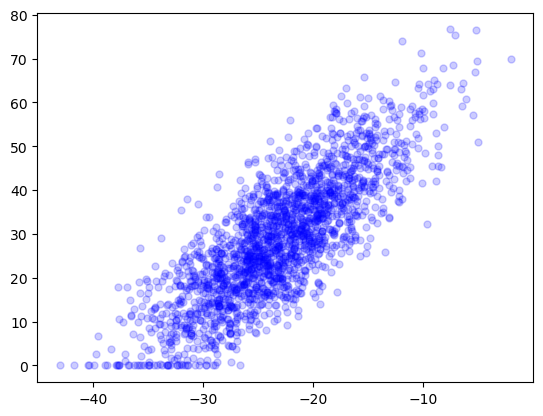

In [10]:
test = Molecule()
parse_input_file('dft-data/CH-H',test)
#thermo(test, temperature)
compute_ensemble(test)

successfully parsed file CH2CH3-H


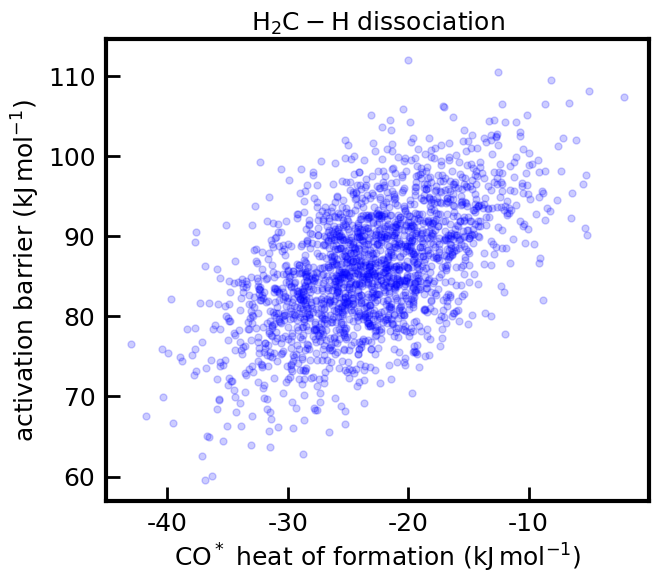

In [19]:
test = Molecule()
parse_input_file('CH2CH3-H',test)
compute_ensemble(test)